## Prototype for Conformalized Survival Analysis with Right-Censoring

This notebook demonstrates the performance of a new prototype method to calibrate lower confidence bounds for survival times under right-censoring.
This method used imputation of unobserved censoring times to obtain an artificial data set with type-I censoring, and then applies Candes' method.
The methods are implemented in the accompanying "utils" R scripts.

In [1]:
# Load required libraries
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
library(survival)
library(ggsurvfit)
library(grf)
library(cfsurvival)

## Generate some survival data

In [2]:
# Generate data from the Log-normal model (Mvt + Heterosc.) of Candes et al. (Table 1)
source("utils_data_new.R")

# Numbers of features (>= 10)
num_features <- 10

# Create an instance of SurvivalDataGenerator
# Supported models:
#  - LogNormalSurvivalGenerator
#  - WeibullSurvivalGenerator
generator <- LogNormalSurvivalGenerator$new(num_features = num_features)

# Sample sizes
num_samples_train <- 2000
num_samples_cal <- 1000
num_samples_test <- 1000


# Set random seet
set.seed(2024)

# Generate training, calibration, and test data
# (including true event and censoring times)
data.train.oracle <- generator$sample_survival_data(num_samples_train)
data.cal.oracle <- generator$sample_survival_data(num_samples_cal)
data.test.oracle <- generator$sample_survival_data(num_samples_test)

# Remove true event and censoring times from the data (right-censoring)
data.train <- data.train.oracle |> select(-event_time, -censoring_time)
data.cal <- data.cal.oracle |> select(-event_time, -censoring_time)
data.test <- data.test.oracle |> select(-event_time, -censoring_time)

# Remove only true event times from the data (type-I censoring)
data.train.t1 <- data.train.oracle |> select(-event_time)
data.cal.t1 <- data.cal.oracle |> select(-event_time)
data.test.t1 <- data.test.oracle |> select(-event_time)

Let's take a look at the data

In [3]:
# Summarize data under type-I censoring
data.train.oracle |>
    summarise(Observations=n(), Events = sum(status), 
              `Median observed time`=median(time),
              `Median observed event time`=median(time[status]),
              `Median censoring time` = median(censoring_time))

Observations,Events,Median observed time,Median observed event time,Median censoring time
<int>,<int>,<dbl>,<dbl>,<dbl>
2000,1638,6.079328,1.568274,22.78619


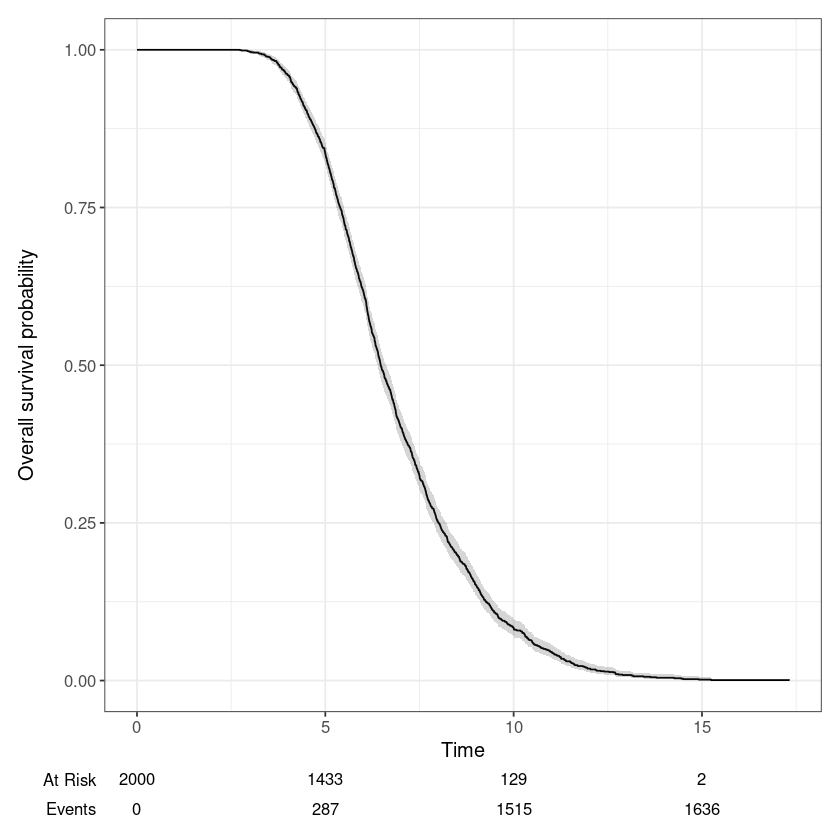

In [4]:
# Kaplan-Meier plot
survfit2(Surv(time, status) ~ 1, data = data.train) |> 
  ggsurvfit() +
  labs(
    x = "Time",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

Compare true event and censoring times.

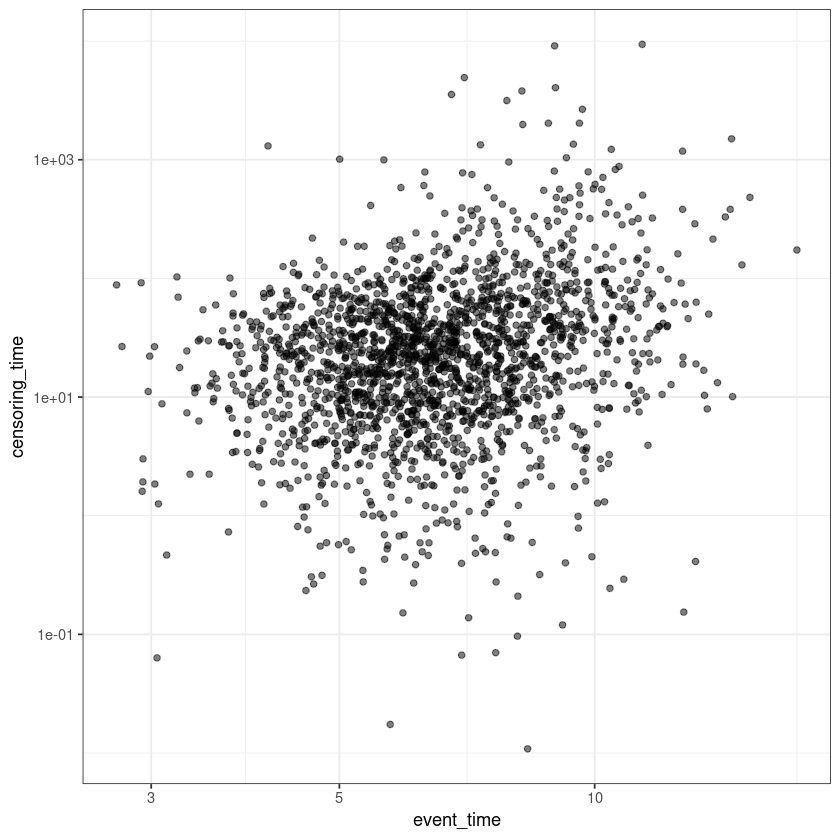

In [5]:
data.train.oracle |>
    ggplot(aes(x=event_time, y=censoring_time)) +
    geom_point(alpha=0.5) +
    scale_y_continuous(trans='log10') +
    scale_x_continuous(trans='log10') +
    theme_bw()

## Fit survival model

Fit a survival model using the training data.

In [6]:
source("utils_survival_new.R")

model_type = "grf"

if(model_type=="grf") {
    # Instantiate GRF survival forest
    surv_model <- GRF_SurvivalForestWrapper$new()
} else if (model_type=="survreg") {
    # Instantiate Cox proportional hazards model
    surv_model <- SurvregModelWrapper$new(dist="weibull")
} else if (model_type=="rf") {
    # Instantiate random forest survival model
    surv_model <- randomForestSRC_SurvivalWrapper$new()
} else {
    stop("Unknown model type!")
}

# Fit the survival model
surv_model$fit(Surv(time, status) ~ ., data = data.train)

## Visualize the model's predictions

Visualize the predicted survival curves for two individuals.

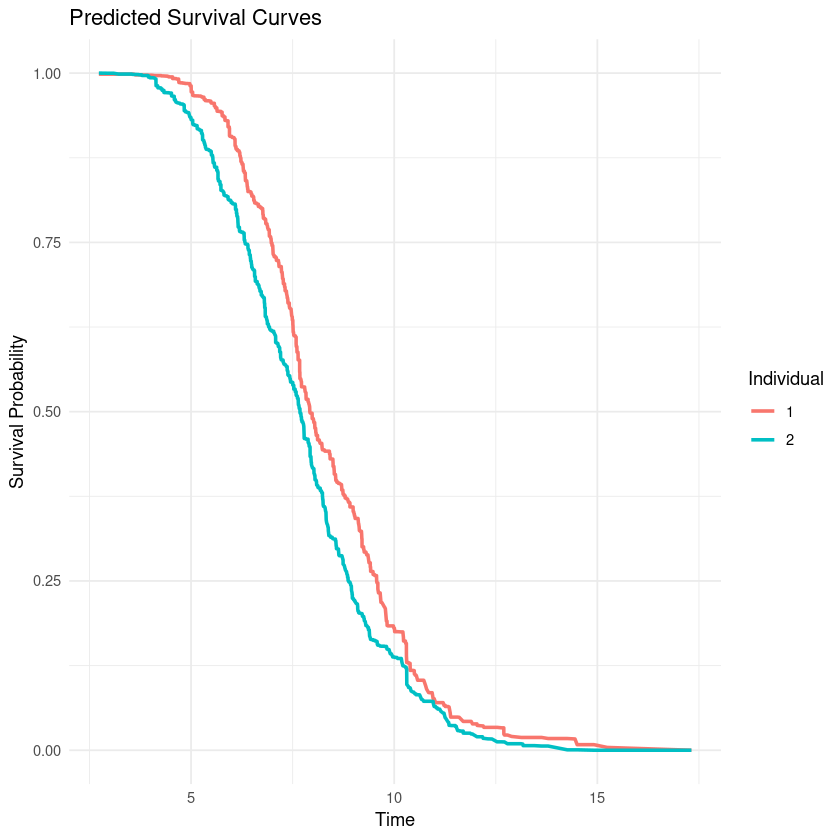

In [7]:
source("utils_plotting_new.R")

idx.predict <- c(1,2)

plot_survival_curves(surv_model, new_data = data.cal[idx.predict,])

Predict survival time quantiles

In [8]:
# Predict survival time quantiles
surv_model$predict_quantiles(data.cal[idx.predict,], probs = c(0.1, 0.5, 0.9))

,Q10%,Q50%,Q90%
,<dbl>,<dbl>,<dbl>
Individual_1,6.082377,7.922876,10.77338
Individual_2,5.315476,7.681493,10.30987


## Estimating the censoring distribution

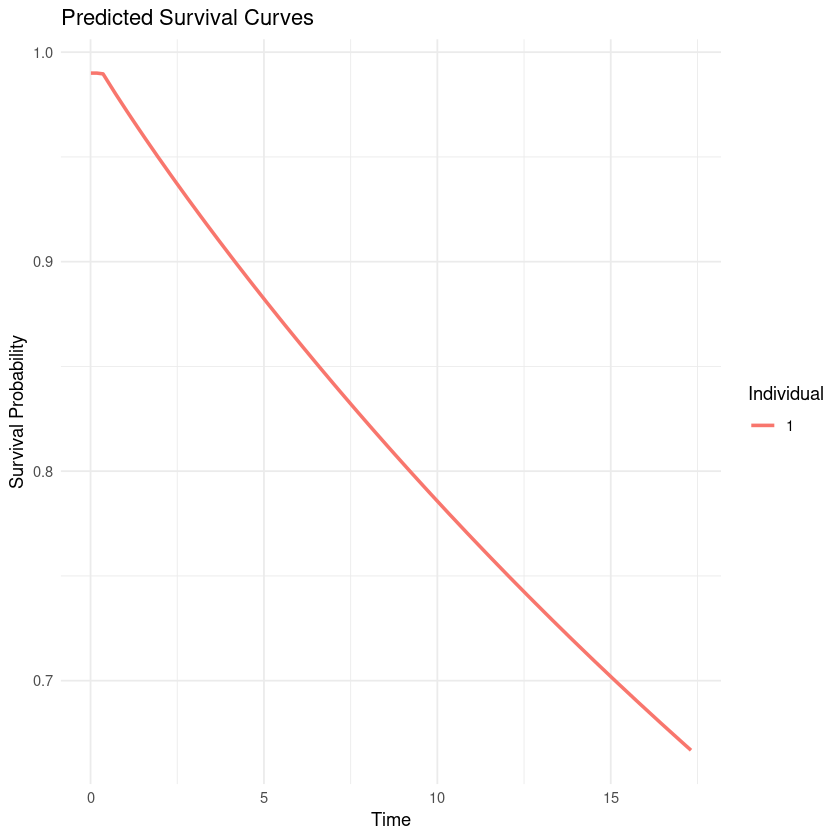

In [9]:
source("utils_censoring.R")

# Create an instance of the CensoringDistribution class with the model
cens_model <- SurvregModelWrapper$new(dist="weibull")

# Create an instance of the CensoringDistribution class with the model
censoring_model <- CensoringDistribution$new(model = cens_model)

# Fit the censoring distribution
censoring_model$fit(data = data.train)

# Plot the censoring distribution for the first individual
idx.predict <- c(1)
plot_survival_curves(censoring_model$model, new_data = data.cal[idx.predict,])

In [10]:
# Re-sample the censoring times
idx.predict <- c(1)

C.new <- sapply(1:20, function(i) {censoring_model$sample_censoring_times(data.cal[idx.predict,], T=data.cal$time[idx.predict])})

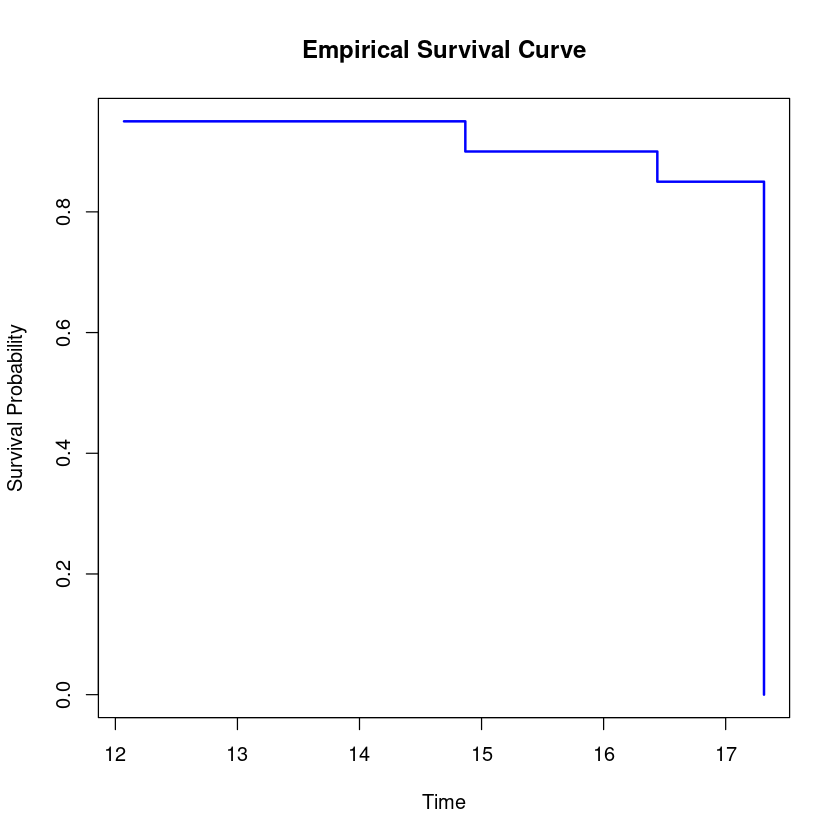

In [11]:
plot_empirical_survival_curve <- function(values) {
  # Remove NA values
  values <- na.omit(values)
    
  # Sort the input values
  sorted_times <- sort(values)
  
  # Calculate the empirical survival probabilities (1 - ECDF)
  n <- length(values)
  empirical_cdf <- (1:n) / n
  survival_probabilities <- 1 - empirical_cdf
  
  # Plot the empirical survival curve
  plot(sorted_times, survival_probabilities, type = "s", 
       xlab = "Time", ylab = "Survival Probability", 
       main = "Empirical Survival Curve", col = "blue", lwd = 2)
}

plot_empirical_survival_curve(C.new)

## Naive CQR

In [12]:
source("utils_conformal.R")

alpha = 0.1
pred.cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.cqr$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>
0.914,3.154336,0.993


## Candes' method (with oracle times)

In [13]:
source("utils_conformal.R")

# Impute the missing censoring times
C.cal <- data.cal.oracle$censoring_time

pred.candes <- predict_Candes(data.test, surv_model, data.cal, C.cal, alpha)

evaluate_bounds(data.test.oracle$time, 
                pred.candes$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>
0.769,5.075913,0.892


## Prototype (with Candes' method, oracle censoring model)

In [15]:
source("utils_conformal.R")

imp_model <- generator
pred.proto <- predict_prototype(data.test, surv_model, imp_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.proto$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>
0.79,4.949208,0.912


## Prototype (with Candes' method, fitted censoring model)

In [16]:
source("utils_conformal.R")
source("utils_censoring.R")

# Create an instance of the CensoringDistribution class with the model
cens_model <- SurvregModelWrapper$new(dist="weibull")

# Create an instance of the CensoringDistribution class with the model
imp_model <- CensoringDistribution$new(model = cens_model)

# Fit the censoring distribution
imp_model$fit(data = data.train)

pred.proto.fit <- predict_prototype(data.test, surv_model, imp_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.proto.fit$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>
0.769,5.075913,0.892
